# Mars Entry-Descent-Landing Mission Scenario

This case study demonstrates using Pacti for formalizing a simplified version of a Mars Entry-Descent-Landing mission scenario based on the following paper: [R. Prakash et al. 2008](#ref1)
and the EDL timeline from https://mars.nasa.gov/internal_resources/961/

In [109]:
from pacti.iocontract import *
from pacti.terms.polyhedra import *
import matplotlib.pyplot as plt

https://mars.nasa.gov/mars2020/timeline/landing/entry-descent-landing/

Section: Atmospheric Entry

https://mars.nasa.gov/resources/25445/perseverance-rover-decelerating-in-the-martian-atmosphere-illustration/

In [110]:
# The rate of deacceleration during atmospheric entry.
atmospheric_v_entry = 20000.0
atmospheric_v_exit = 1600.0
atmospheric_t_entry = 0.0
atmospheric_t_exit = 90.0
atmospheric_min_deacceleration = abs((atmospheric_v_entry - atmospheric_v_exit) / (atmospheric_t_entry - atmospheric_t_exit))
print(f"atmospheric_min_deacceleration={atmospheric_min_deacceleration}")

atmospheric_entry_contract = PolyhedralContract.from_string(
    InputVars=[
      "t0",           # time @ entry
      "v0"            # velocity @ entry
    ],
    OutputVars=[
      "t1",           # time @ exit
      "v1"            # velocity @ exit
    ],
    assumptions=[
      # velocity @ entry
      f"v0 = {atmospheric_v_entry}",

      # time @ entry
      f"t0 = {atmospheric_t_entry}"
    ],
    guarantees=[
      # upper limit on atmospheric entry duration
      f"t0 - t1 <= {atmospheric_t_entry - atmospheric_t_exit}",

      # "v1 <= v0 - (t1 - t0)*atmospheric_min_deacceleration"
      f"v1 - v0 + {atmospheric_min_deacceleration} t1 - {atmospheric_min_deacceleration} t0 <= 0"

      # If the above is replaced with this, we get: ValueError: Assumptions are unfeasible
      # f"v0 - v1 + {atmospheric_min_deacceleration} t1 - {atmospheric_min_deacceleration} t0 <= 0"
    ])

print(atmospheric_entry_contract)

atmospheric_min_deacceleration=204.44444444444446
InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  v0 = 20000.0
  t0 = 0.0
]
G: [
  t0 - t1 <= -90.0
  -204.44444444444446 t0 + 204.44444444444446 t1 - v0 + v1 <= 0.0
]


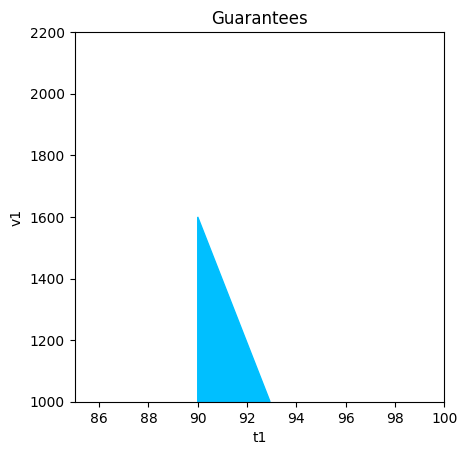

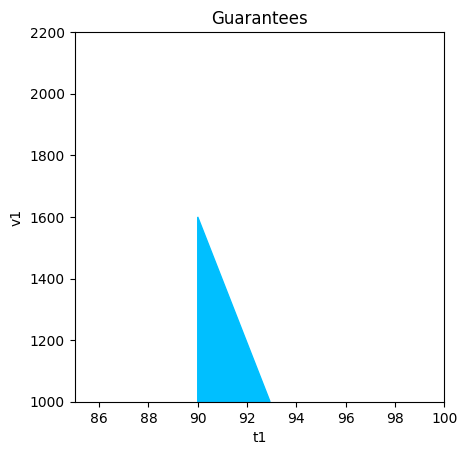

In [111]:
plot_guarantees(
    contract=atmospheric_entry_contract,
    x_var=Var("t1"),
    y_var=Var("v1"),
    var_values={
        Var("t0"):0,
        Var("v0"):20000.0
    },
    x_lims=(85,100),
    y_lims=(1000, 2200)
)

In [112]:
parachute_v_entry = 1600.0
parachute_v_exit = 320.0
parachute_t_entry = 90.0
parachute_t_exit = 260.0
parachute_min_deacceleration = abs((parachute_v_entry - parachute_v_exit) / (parachute_t_entry - parachute_t_exit))
print(f"parachute_min_deacceleration={parachute_min_deacceleration}")


parachute_deployment_contract = PolyhedralContract.from_string(
    InputVars=[
      "t0",           # entry time
      "v0"            # entry velocity
    ],
    OutputVars=[
      "t1",           # exit time
      "v1"            # exit velocity
    ],
    assumptions=[
      # velocity @ entry
      f"v0 = {parachute_v_entry}",

      # time @ entry
      f"t0 = {parachute_v_exit}"
    ],
    guarantees=[
      # upper limit on atmospheric entry duration
      f"t0 - t1 <= {atmospheric_t_entry - atmospheric_t_exit}",

      # "v1 <= v0 - (t1 - t0)*atmospheric_min_deacceleration"
      f"v1 - v0 + {atmospheric_min_deacceleration} t1 - {atmospheric_min_deacceleration} t0 <= 0"

      # If the above is replaced with this, we get: ValueError: Assumptions are unfeasible
      # f"v0 - v1 + {atmospheric_min_deacceleration} t1 - {atmospheric_min_deacceleration} t0 <= 0"
    ])

print(parachute_deployment_contract)

InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  v0 = 20000.0
   = 0.0
]
G: [
   <= -90.0
  -v0 + v1 <= 0.0
]


In [113]:
plot_guarantees(
    contract=atmospheric_entry_contract,
    x_var=Var("t1"),
    y_var=Var("v1"),
    var_values={
        Var("t0"):0,
        Var("v0"):20000.0
    },
    x_lims=(85,100),
    y_lims=(1000, 2200)
)

ValueError: Assumptions are unfeasible

## References

<a id="ref1"></a> __[R. Prakash et al. 2008](https://ieeexplore.ieee.org/abstract/document/4526283)__

R. Prakash et al., "Mars Science Laboratory Entry, Descent, and Landing System Overview," 2008 IEEE Aerospace Conference, Big Sky, MT, USA, 2008, pp. 1-18, doi: 10.1109/AERO.2008.4526283.
